# hide
title: handling ebay push notifications in python 
tags: ebay api python

In [2]:
# hide
import pandas as pd
from elastipy import Search, query

For the e-commerce developers out there, whether they like what they do or not, the 31th of August 2021 was the deadline to register for a new type of ebay notification. namely [Account Deletion/Closure](https://www.developer.ebay.com/marketplace-account-deletion) notifications.

> eBay provides their users a way to request that their personal data be deleted from eBay's systems, as well as deleted from the systems of all eBay partners who store/display their personal data, including third-party developers integrated with eBay APIs via the eBay Developers Program.

For reasons, i'm one of those third-party devs required to hook into that system. There was an email from *developers.ebay* in March which somehow did not find it's way into my perception. The reminder email was sent during my holidays and the first day back at work was the 31th August ;)

With slightly raised adrenaline levels, we read the documentation and tried to connect to those deletion notifications, without immediate success. 

The first thing to do is to send the correct [challenge response](https://www.developer.ebay.com/marketplace-account-deletion#preparingURL) to ebay. It's not super difficult but it took us until the 1st of September to get it working. Without loosing api access, mind you. 

Here's a [Django](https://www.djangoproject.com/) view that generates the challenge response as the ebay docs require it: 

In [3]:
def challenge_response_view(request):
    try:
        challenge_code = request.GET.get("challenge_code")
        if not challenge_code:
            return HttpResponse(status=500)
        
        verification_token = ...  # read it from database or somewhere
        callback_url = ...        # the full url of this endpoint (including https://)

        response_code = hashlib.sha256(
            (challenge_code + verification_token + callback_url).encode("ascii")
        ).hexdigest()

        return JsonResponse({"challengeResponse": response_code})

    except Exception:
        return HttpResponse(status=500)

Why did it not work? The forums provide a couple of hints and allegations since March 2021.

- The url must not include the term *ebay* because it's protected by copyright. (Funny idea but not true)
- The url must not contain nested paths. (Why should this be important? It's not true)

A range of other speculations and discussions are available, in the manner of *i had the same problem and did ...*

So here's mine: Well, maybe there where issues with the url path previously but it seems not the case anymore. After making sure that **the verification token is not longer than 64 characters** it finally worked after **saving the email address first** in the Account Deletion Notification configuration view before saving the callback url and verification token. All of a sudden, there were notifications streaming in.

As *responsible* developers we need to make sure that only ebay is able to push into our endpoint, not any script kiddy or botnet. Ebay provides a signature header using ECDSA private-public-key cryptography which, as far as i can tell, is super secure. But i can not tell very far because i'm quite overwhelmed by crypto technology at every confrontation. Well, once we where hooked up to the ebay endpoint (almost before the deadline) the signature check could be implemented in due time. 

Here's the validation function using the pure-python library [ecdsa](https://github.com/tlsfuzzer/python-ecdsa). The method is based on the node.js version of the 
[ebay sdk code](https://github.com/eBay/event-notification-nodejs-sdk/blob/main/lib/validator.js) and very helpful insights came from this
[stackoverflow thread](https://stackoverflow.com/questions/59904522/asn1-encoding-routines-errors-when-verifying-ecdsa-signature-type-with-openssl) regarding invalid
lengths of signatures (*should be 64 but is 71*).

In [ ]:
import json
import base64
import hashlib
from typing import Optional

import ecdsa

def validate_ebay_signature(
        payload: bytes, 
        signature_b64: str, 
        cached: bool = True,
) -> Optional[str]:
    """
    Validate an ebay notification request.
    
    If this function does not return None, the validation has 
    failed and the returned value is a *somewhat* descriptive
    error text.

    :param payload: bytes, 
        the payload that has been signed (body of the POST request)
    
    :param signature_b64: str, 
        the base64 encoded signature object as provided by ebay request header 'x-ebay-signature'
    
    :param cached: bool, 
        whether to request the ebay public key (False) or use the cached key if possible (True)
    
    :return None (validation succeeded) or str (validation failed)
    """
    try:
        # the signature in the ebay request header is a base64 encoded json object
        signature = json.loads(base64.b64decode(signature_b64).decode("ascii"))
        # check if required fields are there
        signature["alg"]
        signature["kid"]
        signature["signature"]

    except Exception as e:
        return f"signature decoding failed: {type(e).__name__}: {e}"

    if signature["alg"] != "ecdsa":
        return f"only supporting 'ecdsa' algorithm, got '{signature['alg']}'"

    try:
        # retrieve the public key from ebay notification api
        # https://developer.ebay.com/api-docs/commerce/notification/resources/public_key/methods/getPublicKey
        public_key_info = SomeEbayApi.get_public_key(
            public_key_id=signature["kid"],
            cached=cached,
        )
    except Exception as e:
        return f"error getting ebay public key: {type(e).__name__}: {e}"

    try:
        # validate the PEM format of the public key
        BEGIN = "-----BEGIN PUBLIC KEY-----"
        END = "-----END PUBLIC KEY-----"

        public_key = public_key_info["key"]
        assert public_key.startswith(BEGIN), f"public key not starting with {BEGIN}"
        assert public_key.endswith(END), f"public key not ending with {END}"
        
        # and newlines after header and before footer
        public_key = public_key.replace(BEGIN, BEGIN + "\n").replace(END, "\n" + END)
        
        # create a ecdsa.VerifyingKey instance from the PEM
        public_key = ecdsa.VerifyingKey.from_pem(public_key.encode("ascii"))

    except Exception as e:
        return f"error preparing ebay public key: {type(e).__name__}: {e}\nkey: {public_key_info}"

    try:
        # the actual signature resides inside the signature object
        #   and is a base64 encoded DER represantation 
        signature_bin = base64.b64decode(signature["signature"].encode("ascii"))

        if not public_key.verify(
                signature=signature_bin,
                data=payload,
                hashfunc=hashlib.sha1,
                sigdecode=ecdsa.util.sigdecode_der,
        ):
            return "signature validation failed"
    
    except Exception as e:
        return f"signature validation failed: {type(e).__name__}: {e}"


The `SomeEbayApi` object is just a placeholder for whatever implementation you use. We are automatically creating the api implementation from the swagger files provided by ebay. The `get_public_key` method caches each *kid / key* combination in memory so the api is only queried once after start/restart of the service. 

How does the data look like? Below is the message received after pressing the *test notification* button in the config view.

In [ ]:
{
  "metadata": {
    "topic": "MARKETPLACE_ACCOUNT_DELETION",
    "deprecated": false,
    "schemaVersion": "1.0"
  },
  "notification": {
    "data": {
      "userId": "ma8vp1jySJC",
      "username": "test_user",
      "eiasToken": "nY+sHZ2PrBmdj6wVnY+sEZ2PrA2dj6wJnY+gAZGEpwmdj6x9nY+seQ=="
    },
    "eventDate": "2021-03-19T20:43:59.462Z",
    "publishDate": "2021-03-19T20:43:59.679Z",
    "notificationId": "49feeaeb-4982-42d9-a377-9645b8479411_33f7e043-fed8-442b-9d44-791923bd9a6d",
    "publishAttemptCount": 1
  }
}

These notifications include the **username** (login) of the ebay user that wants to be removed. Well, okay, there needs to be some way of identifying the user to clean up it's data traces in your system. I never understood why ebay is providing the login name in the first place. It's certainly not required to deliver packages and in many cases it's quite personal information.

So, since September the 1st, we are receiving more than 1000 of real deletion requests every day. The users are not tied to an actual merchant that has connected the app to it's ebay account. It's simply **all** requests that happen on ebay which leads to the following conclusion: 

**If you delete your ebay account (or however this notification is triggered) your login name will be posted to every ebay-connected applications in the world.**

Here's a time series for the last few days (resampled to a 30 minutes interval):

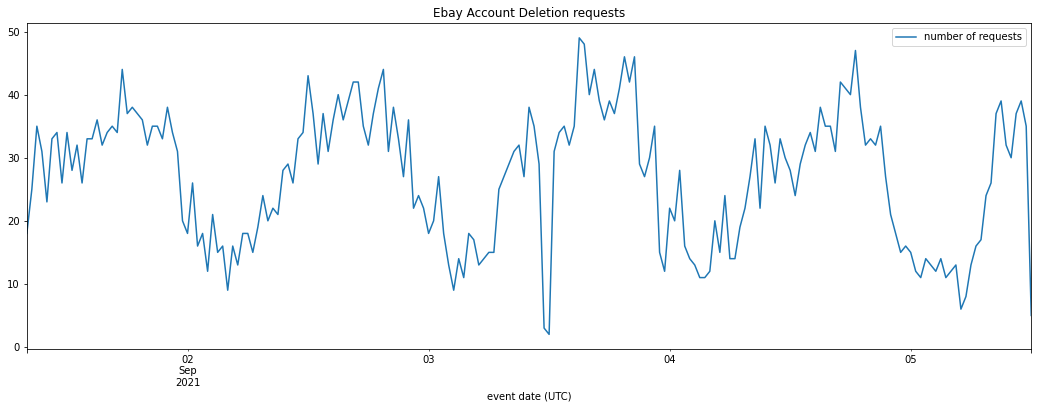

In [91]:
# hide-code
import matplotlib.pyplot as plt

df = pd.read_csv("ebay-deletion-requests.csv", index_col=0).set_index("date")
df = df[df.index >= "2021-09-01"]
df.index = pd.to_datetime(df.index)
df["number of requests"] = 1
df.index.name = "event date (UTC)"
_ = df.resample("30min").sum().plot(figsize=(18, 6), title="Ebay Account Deletion requests")

(The little gap on Sep 3rd was caused by the change of the callback URL from development to production. In case of URL or token change, the challenge by ebay will be renewed and all intermediate requests are discarded. Together with an unrelated technical problem this led to some downtime.)

Great! I don't think these deletion notifications are implemented by ebay in a privacy compliant way but i certainly like to collect such data (e.g. [free parking spaces](https://defgsus.github.io/blog/2021/04/08/one-year-parking.html) or [office appointments](https://github.com/defgsus/office-schedule-scraper)). 

Stay tuned for a post in a year were we can examine the long term trends. 

### Disclaimer

I do not store the **username** field. Trust me!